<a href="https://colab.research.google.com/github/TejaTadepalli/GHW-2022-December/blob/main/Machine%20Learning%20Track/GHW_2022_12_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning

When your algorithm is trying to do something, if it gets better at that task with the addition of more experience (data), then it's doing machine learning.

In [ ]:
!pip install -U --pre tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 20 kB/s 
     |████████████████████████████████| 4.7 MB 65.9 MB/s 
     |████████████████████████████████| 6.0 MB 60.5 MB/s 
     |████████████████████████████████| 439 kB 75.5 MB/s 
     |████████████████████████████████| 1.7 MB 32.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [ ]:
import tensorflow as tf
# How to install Tenserflow in a conda env: conda install -c conda-forge tensorflow
import numpy as np

seed = 42

tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
# here we are using a dataset which has speech-commands

tf.keras.utils.get_file(
    'mini_speech_commands.zip',
    origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip", # location of the file
    extract=True,
    cache_dir='.', cache_subdir="data"
)

182082353/182082353 [==============================] - 5s 0us/step


'./data/mini_speech_commands.zip'

In [ ]:
import os

dataset_path = '/content/data/mini_speech_commands'

os.listdir(dataset_path)
# this will list out all the things in the dataset_path directory


['down', 'stop', 'yes', 'up', 'left', 'README.md', 'go', 'right', 'no']

In [ ]:
"""
/data
  /dogs
     /image_of_dog_1.png
     /image_of_dog_2.png
     ...
  /cats
     /image_of_cat_1.png
     /image_of_cat_2.png
     ...
"""

# A Sample directory structure of how data can be stored...

'\n/data\n  /dogs\n     /image_of_dog_1.png\n     /image_of_dog_2.png\n     ...\n  /cats\n     /image_of_cat_1.png\n     /image_of_cat_2.png\n     ...\n'

In [ ]:
# keras will turn the "directory-structure" into a dataset for us

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(   # we tell it what to do to generate our dataset
    directory=dataset_path,         # this will be "cats" and "dogs"
    batch_size=64,                  # "BATCH" is like a set of Q&A and then it will check it acc to the data... if it is getting a wrong answer, 
                                    # then it will change the model accordingly... here it means that it will check the data for "64-Q&A"

    validation_split=0.2,           # this is used for the training nd testing part
    seed=seed,
    output_sequence_length=16000,   # This is the "fixed" length that we want for the output_sequence (OUTPUT)
    subset='both',                  # this will return both the training and testing(validation) datasets
)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
label_names = np.array(train_ds.class_names)

label_names

array(['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes'],
      dtype='<U5')

In [ ]:
train_ds.element_spec

# TensorSpec is a "specification" of how an array looks like... so basically here:
# 1. The above one might correspond to the Audio Input ("16000 is the length of samples/individual recordings we have"... the 3rd None refers to the "STEREO OUTPUT")
# 2. The bottom one might correspond to the Label ("just a number")

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
# Creating a function to remove the STEREO OUTPUT

def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)  # we are "squeezing" the last axis
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)    # we are telling how to squeeze the dataset
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

# if we do something to our training dataset, we will need to bring a change in the validation dataset...
# MAP() function is used to apply "the squeeze function to the entire dataset"

In [ ]:
train_ds.element_spec

# hence we have just said every element is just a collection of 16000 things

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
# We are trying to get a "dummy form" for our python-generated datasets

for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

  # hence we are getting a "batch" of 16000 audio samples and 1 label where 64 questions...

(64, 16000)
(64,)


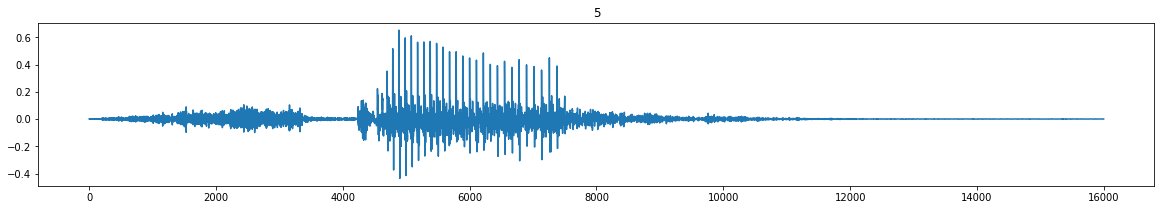

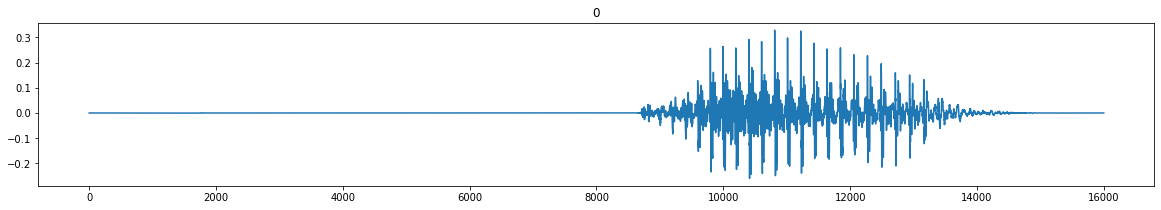

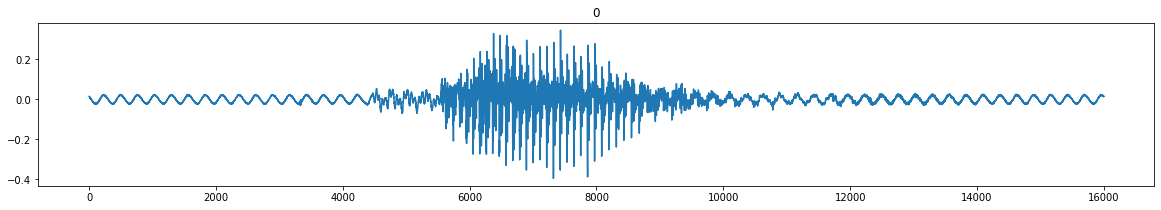

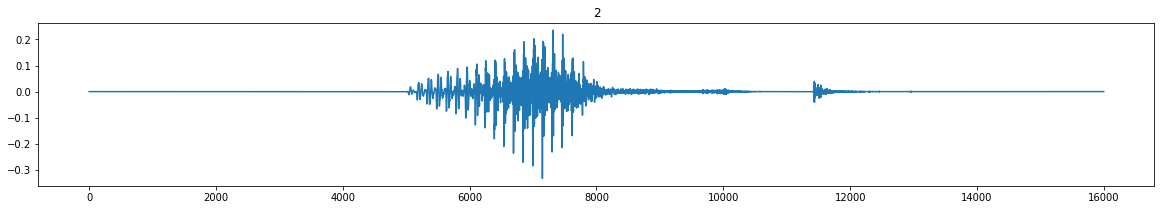

In [ ]:
import matplotlib.pyplot as plt

for i in range(4):
  plt.figure(figsize=(20,3))
  plt.plot(example_audio[i].numpy())
  label = example_labels[i]
  plt.title(int(label))

  # this is without the label_name

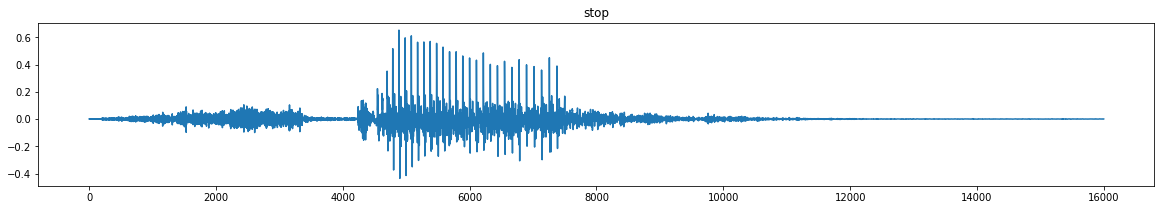

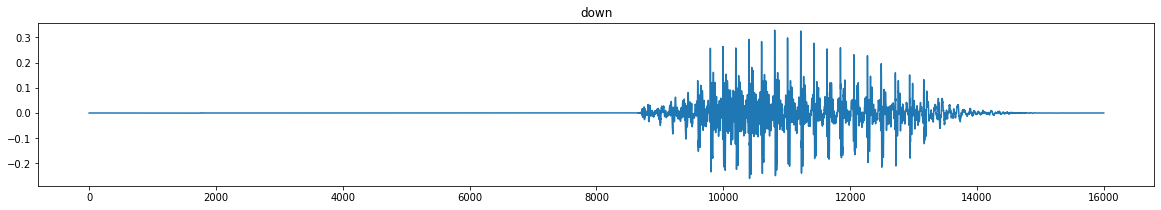

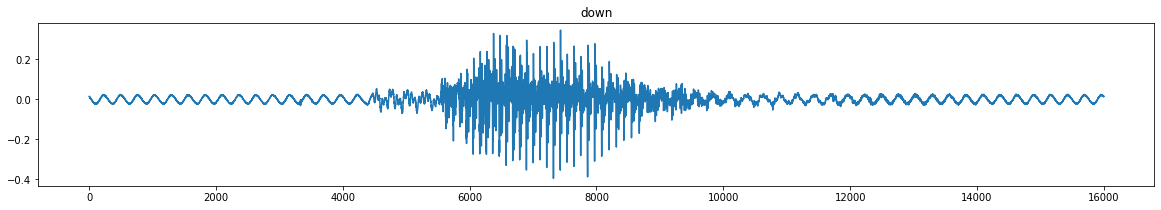

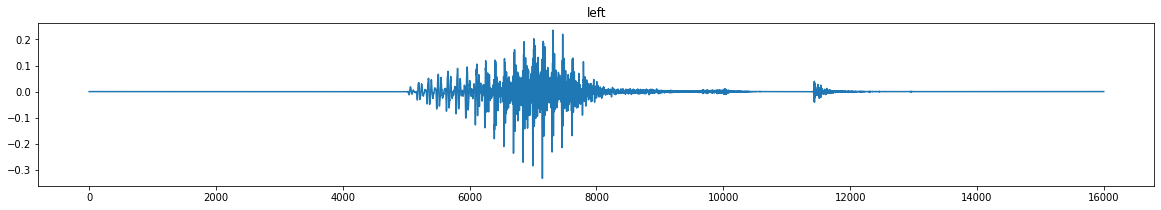

In [ ]:
import matplotlib.pyplot as plt

for i in range(4):
  plt.figure(figsize=(20,3))
  plt.plot(example_audio[i].numpy())
  label = label_names[example_labels[i]]
  plt.title(label)

In [ ]:
# Now we are trying to find a way to remove the background-noise in the 3rd graph(consistent wave)
# it's like when you take the music out of a song to leave only the vocals...

In [ ]:
def get_spectrogram(waveform):
  # This does a fourier transform, pulling out the individual frequencies that make up our sound (BREAKING DOWN OUR DATA FOR SIMPLIFICATION)
  spectrogram = tf.signal.stft(waveform, frame_length=256, frame_step=128)
  # frame_length is the how many different samples does it look at once to search for frequencies
  # frame_step is "rolling-window"

  # This gets rid of the "phase data" (which basically if we're in the negative or positive part of the curve)
  spectrogram = tf.abs(spectrogram)

  # This lets us render our data as a pretty image
  spectrogram = spectrogram[...,tf.newaxis]
  return spectrogram

In [ ]:
def plot_spectrogram(spectrogram):
  if len(spectrogram.shape) > 2:  # we are checking the length of the spectrogram (we have 3 dimensions.. hence we are checking for the 2)
    assert len(spectrogram.shape) == 3    # we will make an assumption and then assert will check if the assumption is true for our dimensionality
    spectrogram = np.squeeze(spectrogram, axis=-1)  # we are removing the last part of the dimensions
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  plt.pcolormesh(X, Y, log_spec)
  

In [ ]:
current_audio = example_audio[0]    # taking a sample audio
current_label = example_labels[0]   # taking its label

current_audio, current_label

# we can see that in current_audio it includes data for the audio sample
# we can see that in current_label it includes the label number for that audio sample

(<tf.Tensor: shape=(16000,), dtype=float32, numpy=
 array([ 0.        , -0.0005188 ,  0.00012207, ...,  0.00039673,
         0.0005188 ,  0.00027466], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int32, numpy=5>)

In [ ]:
len(current_audio)

16000

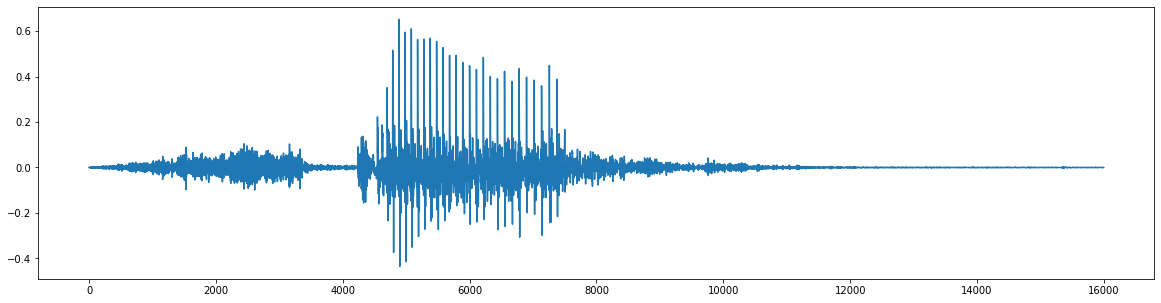

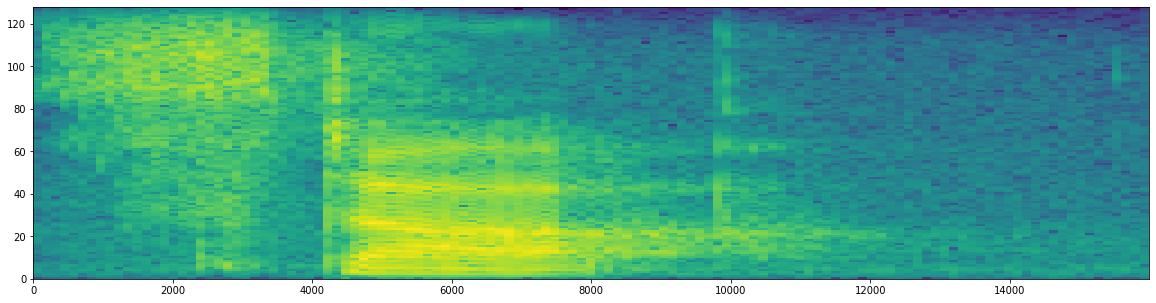

In [ ]:
# Now we will plot for the above example

plt.figure(figsize=(20,5))
timescale = np.arange(16000)
plt.plot(timescale, current_audio.numpy())

spectrogram = get_spectrogram(current_audio)
plt.figure(figsize=(20,5))
plot_spectrogram(spectrogram)

In [ ]:
# the yellow part depicts the volume at that particular time

In [ ]:
spectrogram.shape

TensorShape([124, 129, 1])

In [ ]:
def make_spec_ds(ds):                                                     # it will accept the entire dataset
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),       # lambda function is used for wrapping a function in aditional logic in a line of code
      # this means that it will turn from the fourier-type plot to the newly colored plot for every data
      # IN SHORT: WE ARE APPLYING get_spectrogram FUNCTION TO THE ENTIRE DATASET
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spec_ds = make_spec_ds(train_ds)
val_spec_ds = make_spec_ds(val_ds)

# now we will be turning both datasets from waveforms into spectrograms

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models

input_shape = spectrogram.shape

print('Input shape:', input_shape)

num_labels = len(label_names)

print('Output shape:', num_labels)

Input shape: (124, 129, 1)
Output shape: 8


In [ ]:
# NORMALIZATION LAYER:
# "Take the Loudest and Quietest. Now make them all about the same layer"... smth on a similar scale of SCALING

norm_layer = layers.Normalization()

norm_layer.adapt(data=train_spec_ds.map(map_func=lambda spec, label: spec))   # this will just get a list of label,spectrogram

# with normalization we have made all the spectrograms of all the same volume

In [ ]:
simple_model = models.Sequential([      # building it sequentially "one-above-the-other"
    layers.Input(shape=input_shape),    # we are giving it a shape
    layers.Flatten(),                   # as the shape is big, we will flatten it to make it into one long list
    layers.Dense(128),                  # Dense() means that each and every part will interact with the other data...
    layers.Dense(num_labels),           # this is how the output will be as... "probability for each respective label"
])

In [ ]:
# this is how it will work if it gets a question correct or a question wrong

simple_model.compile(
    optimizer=tf.keras.optimizers.Adam(),                                   # efficient way of optimizing it if we get a question wrong or correct
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),   # 
    metrics='accuracy',                                                     # this is for the accuracy "Question is Correct or Wrong"
)

# Done w/o GPU

history = simple_model.fit(
    train_spec_ds,
    validation_data=val_spec_ds,
    epochs=10,                                                             # how many times to go through the questions in the question-bank
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),     # if it gets to a point where it gets worst and does 3 times bad, then it will stop testing
)

# NEED TO WATCH THIS VIDEO:
## *CNN* => Convolusions
https://www.youtube.com/watch?v=py5byOOHZM8&ab_channel=Computerphile

https://www.youtube.com/watch?v=KuXjwB4LzSA&ab_channel=3Blue1Brown

# DAY 4

In [ ]:
# To test out the GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12232130749357421236
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14398783488
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4482085514324188473
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
# Running the model with this GPU

with tf.device('/device:GPU:0'):
  history = simple_model.fit(
      train_spec_ds,
      validation_data=val_spec_ds,
      epochs=20,
      callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
  )

Epoch 1/20
100/100 [==============================] - 13s 95ms/step - loss: 4.3856 - accuracy: 0.4097 - val_loss: 3.5785 - val_accuracy: 0.4487
Epoch 2/20
100/100 [==============================] - 10s 96ms/step - loss: 2.1789 - accuracy: 0.5242 - val_loss: 3.2095 - val_accuracy: 0.4437
Epoch 3/20
100/100 [==============================] - 9s 87ms/step - loss: 1.5040 - accuracy: 0.5845 - val_loss: 2.2932 - val_accuracy: 0.5013
Epoch 4/20
100/100 [==============================] - 9s 86ms/step - loss: 1.1699 - accuracy: 0.6413 - val_loss: 2.1802 - val_accuracy: 0.5144
Epoch 5/20
100/100 [==============================] - 9s 87ms/step - loss: 0.9917 - accuracy: 0.6786 - val_loss: 2.2694 - val_accuracy: 0.5169
Epoch 6/20
100/100 [==============================] - 18s 177ms/step - loss: 0.8705 - accuracy: 0.7070 - val_loss: 2.1569 - val_accuracy: 0.5150
Epoch 7/20
100/100 [==============================] - 11s 109ms/step - loss: 0.8741 - accuracy: 0.7105 - val_loss: 2.3539 - val_accuracy: 

Text(0, 0.5, 'Loss')

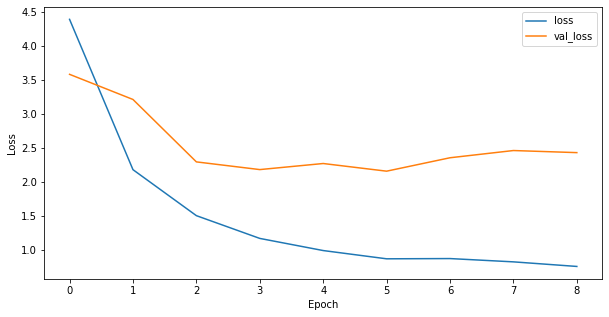

In [ ]:
# Now we will plot it on a graph...
metrics = history.history
plt.figure(figsize=(10,5))
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# loss are values which shows the difference between the result we are get and the result we were supposed to get
# loss is like how far we are from the target

Text(0, 0.5, 'Accuracy')

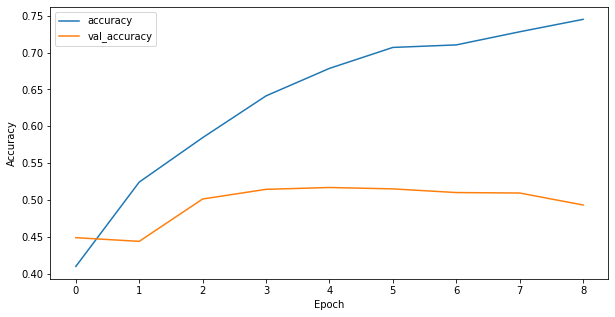

In [ ]:
# Plotting Graph
plt.figure(figsize=(10,5))
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# accuracy is number of correct prediction

In [ ]:
# Convolusion is basically a sliding-window which looks at the things which are next to another

# A More _Convoluted_ Model

In [ ]:
cnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),          # resizing the data accordingly
    layers.Conv2D(32, 3),             # we are using a 2D Convolutional Window
    layers.MaxPooling2D(),            # this is used to collapse and "lay all of the copies of image" on another and look for the brightest parts (YELLOW)
    layers.Flatten(),
    layers.Dense(128),
    layers.Dense(num_labels),
])

cnn_model.summary()                   # this will show a summary of the model

# in the Output Shape for "conv2d" it will show: (None, 30, 30, 32) this means that its dimensions are 30x30 and it has 32 such copies of filters

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 7200)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               921728    
                                                                 
 dense_3 (Dense)             (None, 8)                 1032      
                                                      

In [ ]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics='accuracy',
)

In [ ]:
history = cnn_model.fit(
    train_spec_ds,
    validation_data=val_spec_ds,
    epochs=20,
)

Epoch 1/20
100/100 [==============================] - 20s 118ms/step - loss: 1.6729 - accuracy: 0.4308 - val_loss: 1.5801 - val_accuracy: 0.4737
Epoch 2/20
100/100 [==============================] - 11s 106ms/step - loss: 1.3063 - accuracy: 0.5708 - val_loss: 1.4551 - val_accuracy: 0.5300
Epoch 3/20
100/100 [==============================] - 9s 90ms/step - loss: 1.1409 - accuracy: 0.6284 - val_loss: 1.3969 - val_accuracy: 0.5769
Epoch 4/20
100/100 [==============================] - 10s 100ms/step - loss: 1.0064 - accuracy: 0.6670 - val_loss: 1.3251 - val_accuracy: 0.6019
Epoch 5/20
100/100 [==============================] - 11s 111ms/step - loss: 0.8753 - accuracy: 0.7139 - val_loss: 1.3342 - val_accuracy: 0.6181
Epoch 6/20
100/100 [==============================] - 11s 106ms/step - loss: 0.8017 - accuracy: 0.7364 - val_loss: 1.3613 - val_accuracy: 0.6050
Epoch 7/20
100/100 [==============================] - 11s 106ms/step - loss: 0.7188 - accuracy: 0.7619 - val_loss: 1.3974 - val_accu

If we notice above, we can see that the accuracy is increasing compared to the previous methods... hence this method is getting better...

The best thing about CNN is that they are easy to "parallelize"... we are talking about how it is broken down and in parallel (WITH MULTIPLE COMBINATIONS)...

Text(0, 0.5, 'Accuracy')

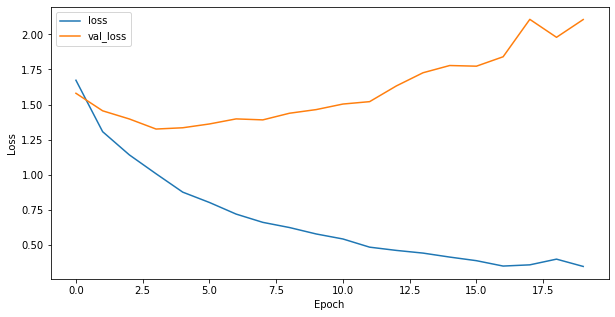

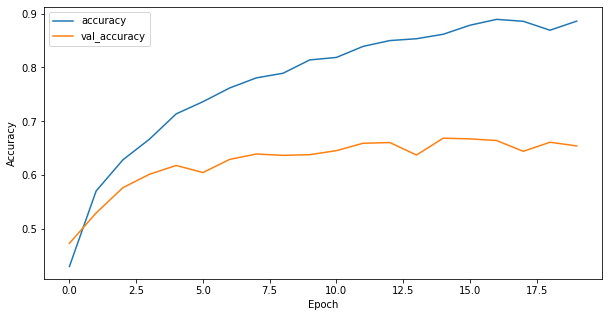

In [ ]:
metrics = history.history
plt.figure(figsize=(10,5))
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure(figsize=(10,5))
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
# now we see that our plot is better but not still going to the maximum... 
# DROPOUT: This is similar to OVERFITTING
# WE WILL NOW GO AND CORRECT OUR MODEL...

In [ ]:
# DROPOUT isn't used b/w complex layers as it will be confusing...

# we can add b/w dense and convolutional layer to be helpful

In [ ]:
cnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    layers.Conv2D(32, 3),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128),
    layers.Dropout(0.25),
    layers.Dense(num_labels),
])

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 7200)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               921728    
                                                      

In [ ]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics='accuracy',
)

In [ ]:
history = cnn_model.fit(
    train_spec_ds,
    validation_data=val_spec_ds,
    epochs=20,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/20
100/100 [==============================] - 11s 96ms/step - loss: 1.7444 - accuracy: 0.4006 - val_loss: 1.5858 - val_accuracy: 0.4737
Epoch 2/20
100/100 [==============================] - 12s 118ms/step - loss: 1.4127 - accuracy: 0.5316 - val_loss: 1.5121 - val_accuracy: 0.4875
Epoch 3/20
100/100 [==============================] - 10s 97ms/step - loss: 1.2836 - accuracy: 0.5795 - val_loss: 1.4293 - val_accuracy: 0.5387
Epoch 4/20
100/100 [==============================] - 10s 98ms/step - loss: 1.1851 - accuracy: 0.6158 - val_loss: 1.4189 - val_accuracy: 0.5537
Epoch 5/20
100/100 [==============================] - 11s 106ms/step - loss: 1.1112 - accuracy: 0.6258 - val_loss: 1.3640 - val_accuracy: 0.5694
Epoch 6/20
100/100 [==============================] - 15s 152ms/step - loss: 1.0298 - accuracy: 0.6550 - val_loss: 1.3289 - val_accuracy: 0.6106
Epoch 7/20
100/100 [==============================] - 10s 97ms/step - loss: 0.9750 - accuracy: 0.6686 - val_loss: 1.3460 - val_accura

In [ ]:
# FROM THIS WE ARE TRYING TO MAKE THE val_loss CURVE TO BECOME BETTER & REMOVE "OVERFITTING" CONDITION
# "accuracy" column might not rise as quickly in this case

Text(0, 0.5, 'Accuracy')

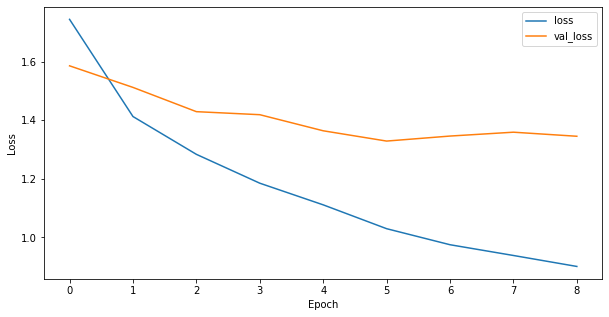

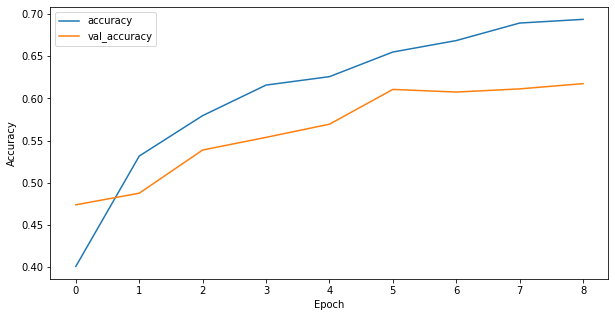

In [ ]:
metrics = history.history
plt.figure(figsize=(10,5))
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure(figsize=(10,5))
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
# loss -> on training data and val loss -> on unseen val data

In [ ]:
# NOW USING WITH THE NORMALIZATION LAYER...

cnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,                         # NORMALIZATION LAYER
    layers.Resizing(32, 32),
    layers.Conv2D(32, 3),
    layers.Conv2D(32, 3),               # ADDITIONAL CONVOLUTIONAL LAYER
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128),
    layers.Dropout(0.25),
    layers.Dense(num_labels),
])

cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 124, 129, 1)      3         
 n)                                                              
                                                                 
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 32)       

In [ ]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics='accuracy',
)

In [ ]:
history = cnn_model.fit(
    train_spec_ds,
    validation_data=val_spec_ds,
    epochs=20,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/20
100/100 [==============================] - 11s 87ms/step - loss: 1.7281 - accuracy: 0.3794 - val_loss: 1.5166 - val_accuracy: 0.4663
Epoch 2/20
100/100 [==============================] - 10s 95ms/step - loss: 1.3719 - accuracy: 0.5494 - val_loss: 1.3975 - val_accuracy: 0.5625
Epoch 3/20
100/100 [==============================] - 9s 87ms/step - loss: 1.1601 - accuracy: 0.6178 - val_loss: 1.2847 - val_accuracy: 0.6225
Epoch 4/20
100/100 [==============================] - 10s 95ms/step - loss: 1.0277 - accuracy: 0.6689 - val_loss: 1.2668 - val_accuracy: 0.6069
Epoch 5/20
100/100 [==============================] - 9s 92ms/step - loss: 0.9747 - accuracy: 0.6853 - val_loss: 1.2046 - val_accuracy: 0.6488
Epoch 6/20
100/100 [==============================] - 9s 86ms/step - loss: 0.8852 - accuracy: 0.7073 - val_loss: 1.1657 - val_accuracy: 0.6694
Epoch 7/20
100/100 [==============================] - 10s 96ms/step - loss: 0.8561 - accuracy: 0.7128 - val_loss: 1.2037 - val_accuracy: 0.

Text(0, 0.5, 'Accuracy')

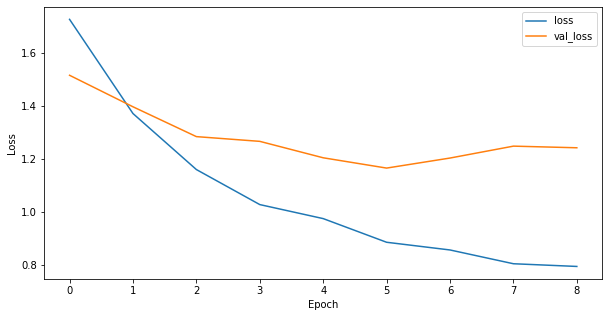

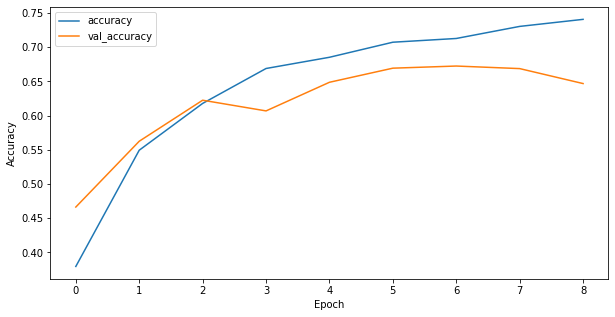

In [ ]:
metrics = history.history
plt.figure(figsize=(10,5))
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure(figsize=(10,5))
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
# HENCE BETTER ACCURACY...
# ALSO THE "accuracy" and "val_accuracy" ARE SIMILAR VALUES SO THAT IS VERY GOOD

In [ ]:
# GENERATING THE PREDICTIONS FROM THE MODEL

y_pred = cnn_model.predict(val_spec_ds)

25/25 [==============================] - 2s 68ms/step


In [ ]:
y_pred

array([[ 0.5307836 , -0.29240242, -1.6208705 , ...,  2.5640283 ,
         4.8919625 , -2.4367275 ],
       [-9.207874  , -1.6861773 , 10.481158  , ..., -5.71952   ,
        -7.0215163 , 34.177242  ],
       [-3.4952283 , -2.4423313 ,  3.3562763 , ...,  8.535574  ,
         0.70986605,  9.376463  ],
       ...,
       [ 4.104745  ,  3.1680918 , -0.36872345, ..., -2.7649426 ,
        -6.494339  ,  2.0954933 ],
       [ 0.38521007,  0.953006  ,  3.4648142 , ..., -2.193777  ,
        -7.385414  , 16.571135  ],
       [ 1.5292863 , -0.28150588,  0.75460833, ...,  3.1788013 ,
        -3.87387   ,  7.96361   ]], dtype=float32)

In [ ]:
# As this output is not how we expect it(according to labels), we need to understand this
# this current output is the probabilities of the data...
label_names , y_pred[0]

(array(['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes'],
       dtype='<U5'),
 array([ 0.5307836 , -0.29240242, -1.6208705 , -0.6229819 , -0.47911054,
         2.5640283 ,  4.8919625 , -2.4367275 ], dtype=float32))

In [ ]:
# TO UNDERSTAND "argmax" function, we will use the following example...

my_array = np.array([
    # a, b,  c, d
    [90, 5, 0, 5],
    [25, 50, 25, 0],
])

tf.argmax(my_array, axis=1)

# argmax => what is the index for the maximum values in these rows...

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>

In [ ]:
y_pred = tf.argmax(y_pred, axis=1)    # we will find it for the current dataset according to particular labels
y_pred

<tf.Tensor: shape=(1600,), dtype=int64, numpy=array([6, 7, 7, ..., 0, 7, 7])>

In [ ]:
# NOW FINDING THE "TRUE" VALUES...

y_true = tf.concat(list(val_spec_ds.map(lambda audio, label: label)), axis=0)
y_true

<tf.Tensor: shape=(1600,), dtype=int32, numpy=array([6, 7, 5, ..., 0, 7, 7], dtype=int32)>

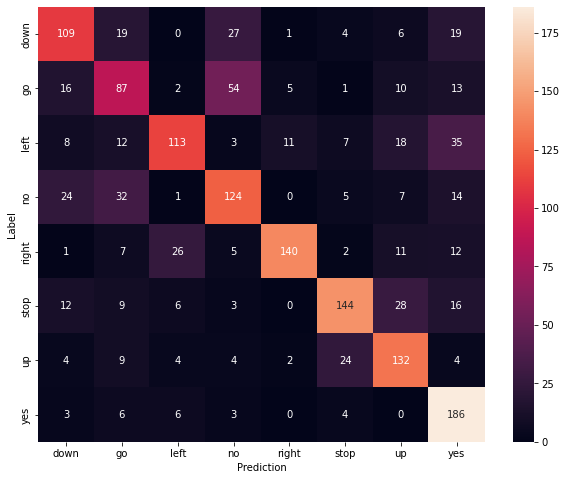

In [ ]:
# NOW WE WILL FIND AND COMPUTE THE CONFUSION-MATRIX...

import seaborn as sns

confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)   # passing the true and prediction values

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
# Here the LABEL column is the correct column and PREDICTION column is the column that we have labelled it as
# DARK color means that it is low in number and the lighter colors means that it is large in amount
# Another use case for this is to understand how and when the model "reacts" in certain conditions so as to figure where our model may have messed up...

#We went and saw the following link: 
https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

In [ ]:
# Now we will create the weights for each of these label_names...

list(enumerate(label_names))

[(0, 'down'),
 (1, 'go'),
 (2, 'left'),
 (3, 'no'),
 (4, 'right'),
 (5, 'stop'),
 (6, 'up'),
 (7, 'yes')]

In [ ]:
# Lets say that "no" and "stop" labels are the most important among these...
# dictionary is being used

class_weight = {
    0: 1,
    1: 1,
    2: 1,
    3: 4,
    4: 1,
    5: 4,
    6: 1,
    7: 1,
}

In [ ]:
# we are going to run this model again to see if it makes any difference with the "label-weight" concept

cnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Resizing(32, 32),
    layers.Conv2D(32, 3),
    layers.Conv2D(32, 3),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128),
    layers.Dropout(0.25),
    layers.Dense(num_labels),
])

cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 124, 129, 1)      3         
 n)                                                              
                                                                 
 resizing_3 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)       

In [ ]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics='accuracy',
)

In [ ]:
history = cnn_model.fit(
    train_spec_ds,
    validation_data=val_spec_ds,
    epochs=20,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
    class_weight=class_weight,
)

Epoch 1/20
100/100 [==============================] - 11s 95ms/step - loss: 2.6221 - accuracy: 0.3013 - val_loss: 1.7204 - val_accuracy: 0.3631
Epoch 2/20
100/100 [==============================] - 10s 96ms/step - loss: 2.1277 - accuracy: 0.4136 - val_loss: 1.5303 - val_accuracy: 0.4319
Epoch 3/20
100/100 [==============================] - 10s 98ms/step - loss: 1.8150 - accuracy: 0.4973 - val_loss: 1.4793 - val_accuracy: 0.4837
Epoch 4/20
100/100 [==============================] - 9s 92ms/step - loss: 1.6497 - accuracy: 0.5473 - val_loss: 1.4160 - val_accuracy: 0.5213
Epoch 5/20
100/100 [==============================] - 10s 99ms/step - loss: 1.5517 - accuracy: 0.5753 - val_loss: 1.3988 - val_accuracy: 0.5437
Epoch 6/20
100/100 [==============================] - 9s 91ms/step - loss: 1.5205 - accuracy: 0.5989 - val_loss: 1.3321 - val_accuracy: 0.5725
Epoch 7/20
100/100 [==============================] - 10s 98ms/step - loss: 1.3457 - accuracy: 0.6302 - val_loss: 1.3834 - val_accuracy: 0

Text(0, 0.5, 'Accuracy')

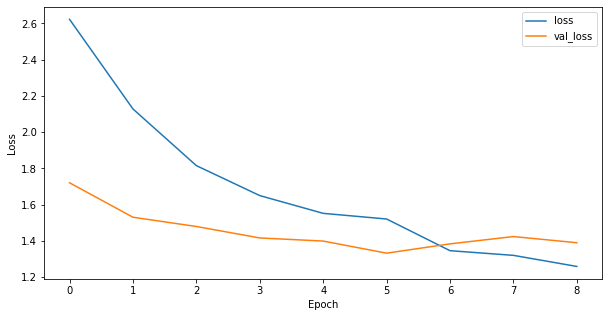

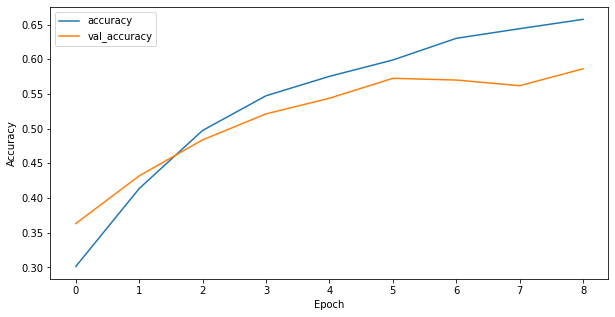

In [ ]:
metrics = history.history
plt.figure(figsize=(10,5))
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure(figsize=(10,5))
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
y_pred = cnn_model.predict(val_spec_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spec_ds.map(lambda audio, label: label)), axis=0)

y_pred, y_true

25/25 [==============================] - 2s 69ms/step


(<tf.Tensor: shape=(1600,), dtype=int64, numpy=array([6, 7, 5, ..., 0, 7, 7])>,
 <tf.Tensor: shape=(1600,), dtype=int32, numpy=array([6, 7, 5, ..., 0, 7, 7], dtype=int32)>)

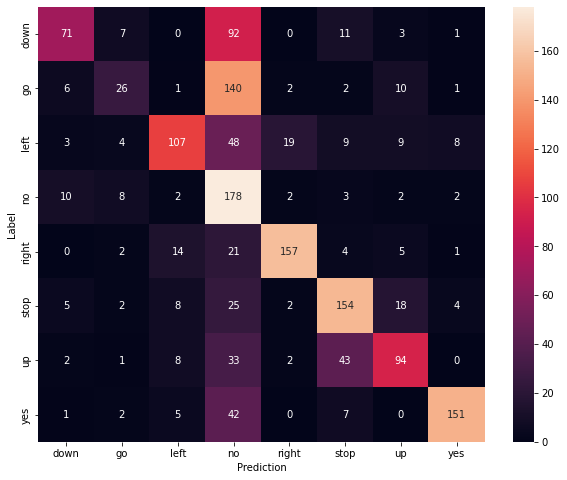

In [ ]:
# NOW WE WILL FIND AND COMPUTE THE CONFUSION-MATRIX OF THE UPDATED MODEL WITH "WEIGHT-LABEL" APPROACH...

import seaborn as sns

confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)   # passing the true and prediction values

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
# From the above Confusion Matrix we realise a few things...
# 1. Some things which are "go" are not being classified as "go" but instead as "no"... this is worse from previous Confusion Matrix
# 2. On the other hand, "no" is being labelled as "no" for most of the cases... this has become better from previous Confusion Matrix

# IN MACHINE LEARNING, WE HAVE TO LOOK AT TWO STUFF:
# 1. OVERALL MODEL PERFORMANCE
# 2. REAL THINGS THAT WE CARE ABOUT

# IN REAL-LIFE EXAMPLES, WE LOOK AT BOTH OF THESE STUFF AND MOST IMPORTANTLY THE PERFORMANCE

# BOOK-> THE ETHICAL ALGORITHM:
https://dokumen.pub/the-ethical-algorithm-the-science-of-socially-aware-algorithm-design-0190948205-9780190948207.html